# American Sign Language Recognition

**About :** The data set is a collection of images of alphabets from the American Sign Language, separated in 29 folders which represent the various classes.

**Content :** The training data set contains 87,000 images which are 200x200 pixels. There are 29 classes, of which 26 are for the letters A-Z and 3 classes for SPACE, DELETE and NOTHING.
These 3 classes are very helpful in real-time applications, and classification.
The test data set contains a mere 29 images, to encourage the use of real-world test images.

![IMG](https://i.ibb.co/RD6dqqs/download.png)

In [ ]:
from google.colab import files
files.upload()

In [2]:
# Getting the dataset using Kaggle API
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d grassknoted/asl-alphabet

 99% 1.02G/1.03G [00:08<00:00, 148MB/s]
100% 1.03G/1.03G [00:08<00:00, 125MB/s]


In [3]:
!nvidia-smi -L

GPU 0: Tesla K80 (UUID: GPU-7c661787-eb9f-da1e-35ff-7e1e364d977a)


In [4]:
# downloading helper_functions.py
! wget https://raw.githubusercontent.com/Hrushi11/Dogs_VS_Cats/main/helper_functions.py

--2021-12-04 04:58:42--  https://raw.githubusercontent.com/Hrushi11/Dogs_VS_Cats/main/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10139 (9.9K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]   9.90K  --.-KB/s    in 0s      

2021-12-04 04:58:42 (36.8 MB/s) - ‘helper_functions.py’ saved [10139/10139]



## Importing Dependancies

In [197]:
# Importing Dependancies
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from helper_functions import unzip_data, walk_through_dir, plot_loss_curves, confusion_matrix, make_confusion_matrix

In [6]:
# Unzipping our data
unzip_data("/content/asl-alphabet.zip")

In [7]:
# To delete the zip file
!rm asl-alphabet.zip

In [8]:
# Walkthrough Directories (Train Dataset)
walk_through_dir("/content/asl_alphabet_train")

There are 1 directories and 0 images in '/content/asl_alphabet_train'.
There are 29 directories and 0 images in '/content/asl_alphabet_train/asl_alphabet_train'.
There are 0 directories and 3000 images in '/content/asl_alphabet_train/asl_alphabet_train/Z'.
There are 0 directories and 3000 images in '/content/asl_alphabet_train/asl_alphabet_train/M'.
There are 0 directories and 3000 images in '/content/asl_alphabet_train/asl_alphabet_train/H'.
There are 0 directories and 3000 images in '/content/asl_alphabet_train/asl_alphabet_train/O'.
There are 0 directories and 3000 images in '/content/asl_alphabet_train/asl_alphabet_train/P'.
There are 0 directories and 3000 images in '/content/asl_alphabet_train/asl_alphabet_train/K'.
There are 0 directories and 3000 images in '/content/asl_alphabet_train/asl_alphabet_train/U'.
There are 0 directories and 3000 images in '/content/asl_alphabet_train/asl_alphabet_train/W'.
There are 0 directories and 3000 images in '/content/asl_alphabet_train/asl_al

In [9]:
# Walkthrough Directories (Test Dataset)
walk_through_dir("/content/asl_alphabet_test")

There are 1 directories and 0 images in '/content/asl_alphabet_test'.
There are 0 directories and 28 images in '/content/asl_alphabet_test/asl_alphabet_test'.


## Plotting images from our train dataset

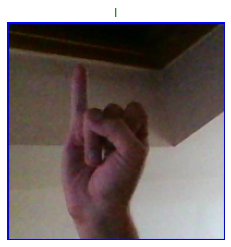

In [10]:
# Plotting a random image from the train dataset
random_class = "/content/asl_alphabet_train/asl_alphabet_train/" + random.choice(os.listdir("/content/asl_alphabet_train/asl_alphabet_train"))
random_filepath = random_class + "/" + random.choice(os.listdir(random_class))
img = plt.imread(random_filepath)
label = random_filepath.split("/")[4]
plt.imshow(img/255)
plt.axis(False)
plt.title(label, color="green"); 

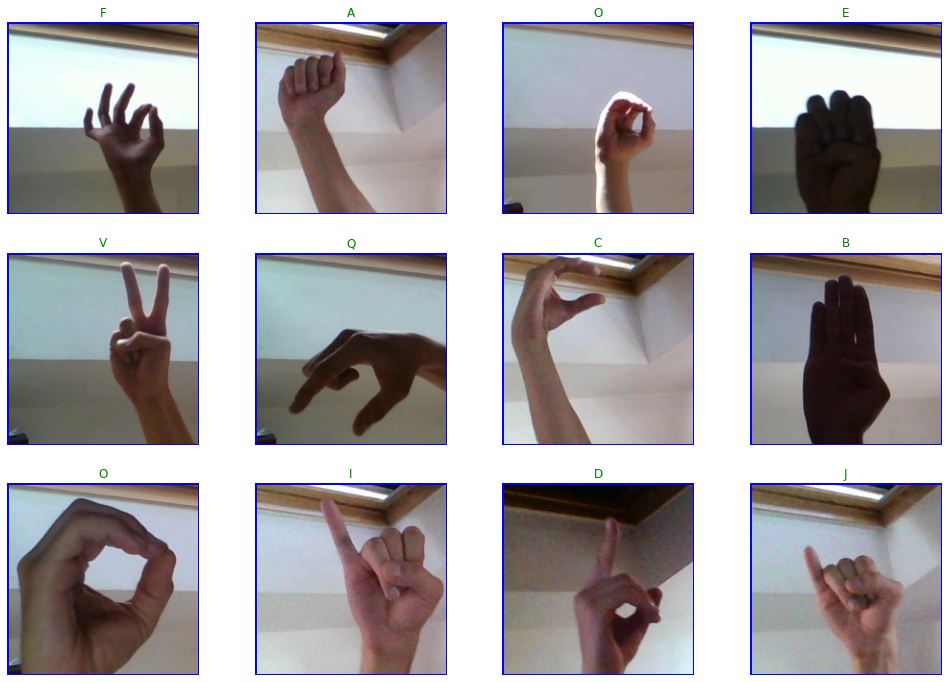

In [216]:
# Plot multiple random images from the dataset
plt.figure(figsize=(17,12))
for i in range(12):
  random_class = "/content/asl_alphabet_train/asl_alphabet_train/" + random.choice(os.listdir("/content/asl_alphabet_train/asl_alphabet_train"))
  random_filepath = random_class + "/" + random.choice(os.listdir(random_class))
  img = plt.imread(random_filepath)
  label = random_filepath.split("/")[4]

  plt.subplot(3, 4, i+1)
  plt.axis(False)
  plt.title(label, color="green")
  plt.imshow(img/255);

## Preparing data for training the model

In [12]:
data_gen = ImageDataGenerator(validation_split=0.2)

In [13]:
# Creating train dataset
train_data = data_gen.flow_from_directory(directory="/content/asl_alphabet_train/asl_alphabet_train",
                                          batch_size=32,
                                          seed=42,
                                          subset="training",
                                          target_size=(200, 200))

# Creating validation dataset
val_data = data_gen.flow_from_directory(directory="/content/asl_alphabet_train/asl_alphabet_train",
                                        batch_size=32,
                                        seed=42,
                                        subset="validation",
                                        target_size=(200, 200))

Found 69600 images belonging to 29 classes.
Found 17400 images belonging to 29 classes.


In [14]:
len(train_data), len(val_data)

(2175, 544)

## Building the Model

In [15]:
# Creating base model
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Building the model
inputs = tf.keras.Input(shape=(200, 200, 3), name="input_layer")
x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling")(x)
outputs = tf.keras.layers.Dense(len(train_data.class_indices), activation="softmax", name="output_layer")(x)
model_1 = tf.keras.Model(inputs, outputs)

# Compiling the model
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

16719872/16705208 [==============================] - 0s 0us/step


In [16]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 200, 200, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling (Glo  (None, 1280)             0         
 balAveragePooling2D)                                            
                                                                 
 output_layer (Dense)        (None, 29)                37149     
                                                                 
Total params: 4,086,720
Trainable params: 37,149
Non-trainable params: 4,049,571
_________________________________________________________________


In [17]:
# Fit the model
history_1 = model_1.fit(train_data,
                        epochs=5,
                        batch_size=32,
                        validation_data=val_data,
                        callbacks=[tf.keras.callbacks.ModelCheckpoint("/content/drive/MyDrive/ASL-Model",
                                                                      monitor="accuracy",
                                                                      save_best_only=False)])

Epoch 1/5
2175/2175 [==============================] - ETA: 0s - loss: 0.2956 - accuracy: 0.9570INFO:tensorflow:Assets written to: /content/drive/MyDrive/ASL-Model/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


2175/2175 [==============================] - 355s 157ms/step - loss: 0.2956 - accuracy: 0.9570 - val_loss: 0.3858 - val_accuracy: 0.8911
Epoch 2/5
2175/2175 [==============================] - ETA: 0s - loss: 0.0343 - accuracy: 0.9978INFO:tensorflow:Assets written to: /content/drive/MyDrive/ASL-Model/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


2175/2175 [==============================] - 333s 153ms/step - loss: 0.0343 - accuracy: 0.9978 - val_loss: 0.3507 - val_accuracy: 0.8893
Epoch 3/5
2175/2175 [==============================] - ETA: 0s - loss: 0.0138 - accuracy: 0.9993INFO:tensorflow:Assets written to: /content/drive/MyDrive/ASL-Model/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


2175/2175 [==============================] - 335s 154ms/step - loss: 0.0138 - accuracy: 0.9993 - val_loss: 0.3003 - val_accuracy: 0.9039
Epoch 4/5
2175/2175 [==============================] - ETA: 0s - loss: 0.0068 - accuracy: 0.9997INFO:tensorflow:Assets written to: /content/drive/MyDrive/ASL-Model/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


2175/2175 [==============================] - 337s 155ms/step - loss: 0.0068 - accuracy: 0.9997 - val_loss: 0.3013 - val_accuracy: 0.9067
Epoch 5/5
2175/2175 [==============================] - ETA: 0s - loss: 0.0037 - accuracy: 0.9999INFO:tensorflow:Assets written to: /content/drive/MyDrive/ASL-Model/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


2175/2175 [==============================] - 337s 155ms/step - loss: 0.0037 - accuracy: 0.9999 - val_loss: 0.3185 - val_accuracy: 0.9054


In [18]:
# Loading in the best_model
model = tf.keras.models.load_model("/content/drive/MyDrive/ASL-Model")
model.evaluate(val_data)

544/544 [==============================] - 59s 106ms/step - loss: 0.3185 - accuracy: 0.9054


[0.3185272812843323, 0.9054023027420044]

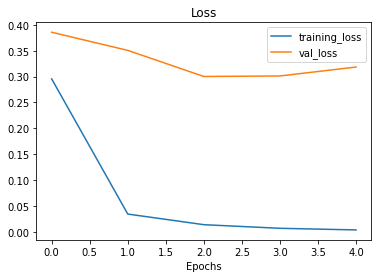

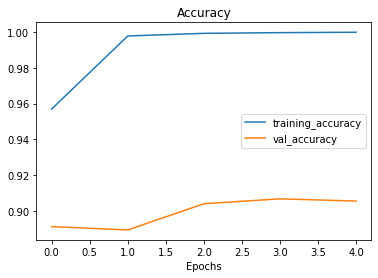

In [161]:
plot_loss_curves(history_1)

## Making predictions on the Model

In [29]:
# Validation file names
val_filenames = val_data.filepaths
val_filenames[:5]

['/content/asl_alphabet_train/asl_alphabet_train/A/A1.jpg',
 '/content/asl_alphabet_train/asl_alphabet_train/A/A10.jpg',
 '/content/asl_alphabet_train/asl_alphabet_train/A/A100.jpg',
 '/content/asl_alphabet_train/asl_alphabet_train/A/A1000.jpg',
 '/content/asl_alphabet_train/asl_alphabet_train/A/A1001.jpg']

In [31]:
# Generating val labels
val_labels = []
for fp in val_filenames:
  val_labels.append(fp.split("/")[4])

val_labels[:5]

['A', 'A', 'A', 'A', 'A']

In [33]:
# Making a Dataframe to store all these values
val_df = pd.DataFrame({"filepaths": val_file_paths,
                       "label": val_labels})
val_df.head()

filepaths label
0  /content/asl_alphabet_train/asl_alphabet_train...     A
1  /content/asl_alphabet_train/asl_alphabet_train...     A
2  /content/asl_alphabet_train/asl_alphabet_train...     A
3  /content/asl_alphabet_train/asl_alphabet_train...     A
4  /content/asl_alphabet_train/asl_alphabet_train...     A

In [34]:
data_gen = ImageDataGenerator()
val_data_df = data_gen.flow_from_dataframe(val_df,
                                           directory="/content/asl_alphabet_train",
                                           x_col="filepaths",
                                           y_col="label",
                                           target_size=(200, 200),
                                           shuffle=False)
len(val_data_df)

Found 17400 validated image filenames belonging to 29 classes.


544

In [35]:
# Making predictions on model
val_pred_prob = model.predict(val_data_df)
val_pred_prob[:5]

array([[9.9999785e-01, 2.2545503e-10, 1.7709405e-10, 1.6612154e-14,
        7.8909068e-07, 1.4797295e-14, 1.9244883e-09, 1.1363191e-11,
        1.8427296e-07, 1.5588788e-09, 7.9375756e-10, 8.9470695e-11,
        1.0077292e-06, 2.7311231e-11, 5.3876725e-09, 4.6819590e-14,
        1.7854471e-13, 6.1967476e-10, 8.0949221e-09, 1.0424622e-08,
        2.9982780e-10, 2.8376282e-11, 1.0713694e-14, 3.5308243e-08,
        1.0960829e-12, 2.6392233e-09, 8.7039981e-10, 1.2997056e-12,
        8.8224951e-08],
       [9.9999774e-01, 2.2854113e-10, 5.1309648e-11, 4.6331944e-15,
        1.0045599e-06, 2.9207610e-14, 8.1217194e-10, 3.5736973e-12,
        2.1036476e-08, 5.2561028e-10, 8.2258561e-11, 1.4856706e-11,
        1.1457573e-06, 1.1029621e-11, 2.1011202e-09, 1.1783083e-14,
        9.5868402e-14, 5.0018014e-11, 1.0707760e-08, 2.7928919e-09,
        1.9495359e-10, 8.9445387e-12, 1.6625552e-15, 2.9771218e-08,
        2.2666108e-13, 1.0987198e-09, 8.6367365e-11, 7.4164953e-13,
        2.3610928e-08],


In [36]:
# Predictions class wise
val_preds = tf.argmax(val_pred_prob, axis=1)
val_preds[:5]

<tf.Tensor: shape=(5,), dtype=int64, numpy=array([0, 0, 0, 0, 0])>

In [40]:
# Generating class names
classes = []
for class_ in train_data.class_indices.keys():
  classes.append(class_)

len(classes)

29

In [86]:
classes

['A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'J',
 'K',
 'L',
 'M',
 'N',
 'O',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'U',
 'V',
 'W',
 'X',
 'Y',
 'Z',
 'del',
 'nothing',
 'space']

In [134]:
# To plot the sign lingual of the correspoding character
def plot_letter(letter_1="A", letter_2="B"):
  """
  Plots 2 random sign lingual image of the 
  characters you pass. including 'nothing',
  'del', 'space'

  default -> 'A', 'B'
  """
  dir = "/content/asl_alphabet_train/asl_alphabet_train"
  fp_1 = dir + "/" + letter_1 + "/" + random.choice(os.listdir(dir + "/" + letter_1))
  fp_2 = dir + "/" + letter_2 + "/" + random.choice(os.listdir(dir + "/" + letter_2))
  img1 = plt.imread(fp_1)
  img2 = plt.imread(fp_2)

  # Plotting
  plt.figure(figsize=(10, 7))
  plt.subplot(1, 2, 1)
  plt.imshow(img1)
  plt.axis(False)
  plt.title(letter_1, color="green")

  plt.subplot(1, 2, 2)
  plt.imshow(img2)
  plt.axis(False)
  plt.title(letter_2, color="green");

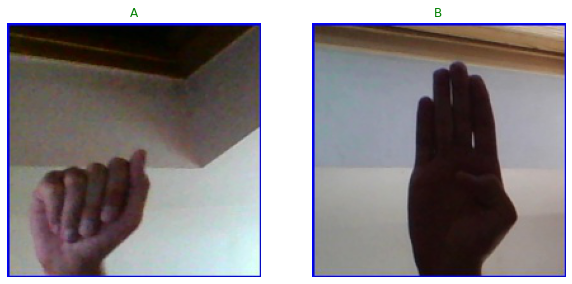

In [135]:
# Plot random letter
plot_letter()

## Plotting Predictions 

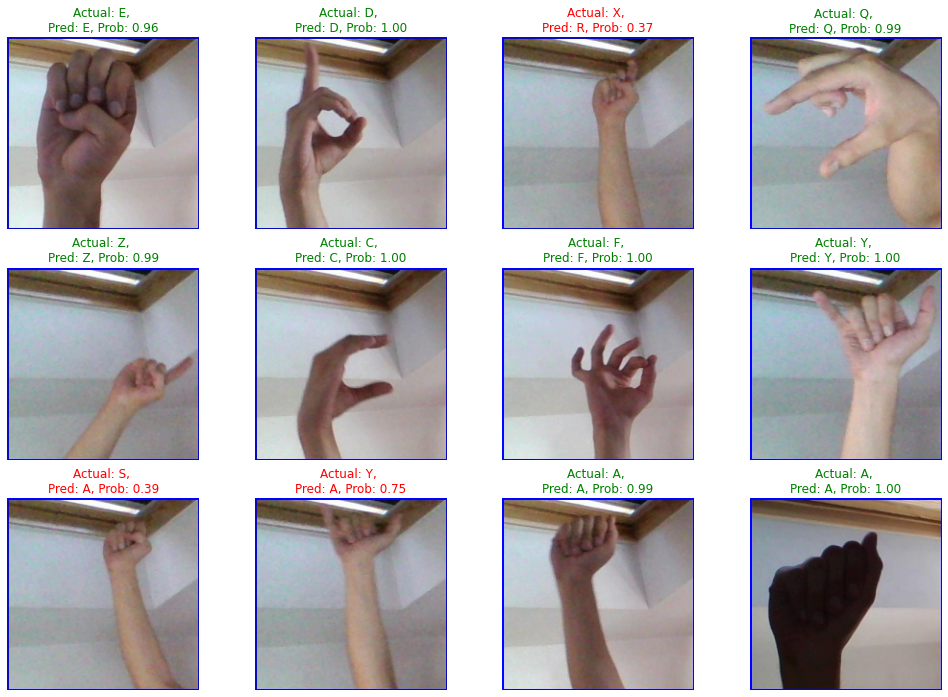

In [215]:
# Plotting the predictions made by the model
random_arr = random.sample(range(len(val_file_paths)), 12)
plt.figure(figsize=(17, 12))
for i in range(12):
  # Getting the img
  img = val_file_paths[random_arr[i]]
  label = val_labels[random_arr[i]]
  prob = np.max(val_pred_prob[random_arr[i]])
  pred = classes[val_preds[random_arr[i]]]
  _title_ = f"Actual: {label}, \nPred: {pred}, Prob: {prob:.2f}"
  col = "green" if label == pred else "red"

  # plotting the imgs
  plt.subplot(3, 4, i+1)
  img = plt.imread(img)
  plt.imshow(img)
  plt.axis(False)
  plt.title(_title_, color=col);

## Wrong Images

In [89]:
# Converting our val_preds into val_pred_labels
val_pred_labels = []
for i in val_preds:
  val_pred_labels.append(classes[i])

val_pred_labels[:5]

['A', 'A', 'A', 'A', 'A']

In [90]:
len(val_pred_labels)

17400

In [105]:
# Creating arrays for wrong predictions
wrng_file_paths = []
wrng_pred_prob = []
wrng_pred = []
actual_label = []
for i in range(len(val_labels)):
  if not val_labels[i] == val_pred_labels[i]:
    wrng_file_paths.append(val_file_paths[i])
    wrng_pred.append(val_pred_labels[i])
    wrng_pred_prob.append(np.max(val_pred_prob[i]))
    actual_label.append(val_labels[i])

len(wrng_file_paths), len(wrng_pred_prob), len(wrng_pred), len(actual_label)

(1646, 1646, 1646, 1646)

In [108]:
# Dataframe for wrong predicted signs
wrng_val_df = pd.DataFrame({"File Paths": wrng_file_paths,
                            "Label": actual_label,
                            "Pred": wrng_pred,
                            "Wrong Pred Prob": wrng_pred_prob})
wrng_val_df.head()

File Paths  ... Wrong Pred Prob
0  /content/asl_alphabet_train/asl_alphabet_train...  ...        0.544043
1  /content/asl_alphabet_train/asl_alphabet_train...  ...        0.615580
2  /content/asl_alphabet_train/asl_alphabet_train...  ...        0.703221
3  /content/asl_alphabet_train/asl_alphabet_train...  ...        0.673621
4  /content/asl_alphabet_train/asl_alphabet_train...  ...        0.638223

[5 rows x 4 columns]

In [110]:
# Saving the dataframe as csv
wrng_val_df.to_csv("Wrong-predictions")

## Plotting wrong images

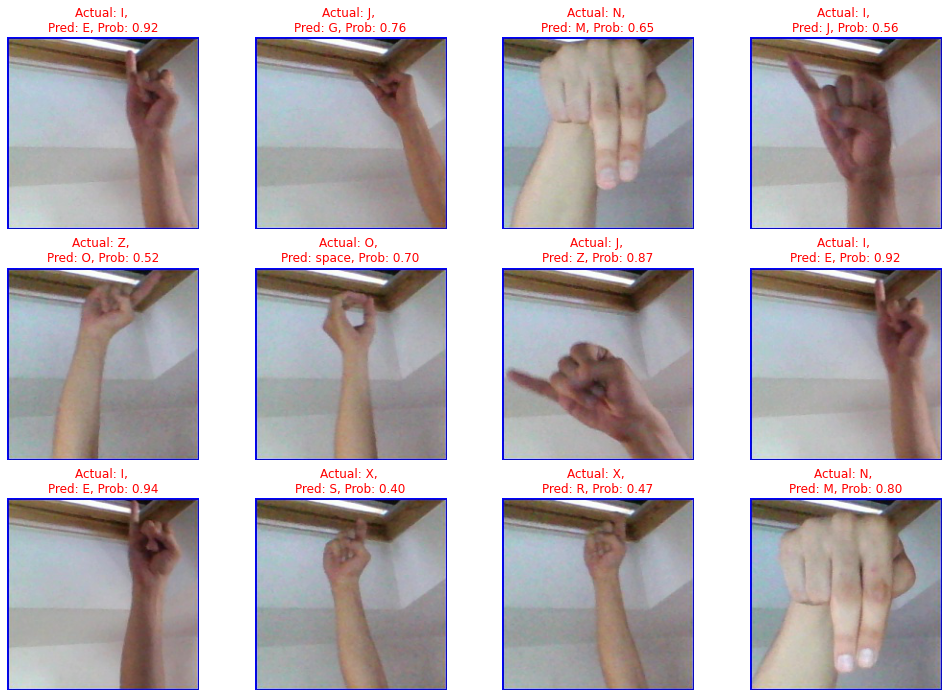

In [213]:
# Plotting wrongly predicted images
plt.figure(figsize=(17, 12))
random_arr = random.sample(wrng_file_paths, 12)
for i in range(12):
  index = np.where(np.array(wrng_file_paths) == random_arr[i])[0][0]
  filepath = wrng_file_paths[index]
  label = actual_label[index]
  pred = wrng_pred[index]
  prob = wrng_pred_prob[index]
  _title_ = f"Actual: {label}, \nPred: {pred}, Prob: {prob:.2f}"

  # Plotting the image
  plt.subplot(3, 4, i+1)
  img = plt.imread(filepath)
  plt.imshow(img)
  plt.axis(False)
  plt.title(_title_, color="red");

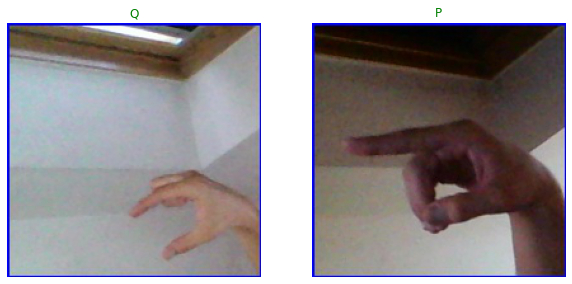

In [142]:
# To check how similar the two signs are
plot_letter("Q", "P")

## Prediction on test images

In [144]:
# Creating a preprocessing function
def load_and_preprocess(filepath):
  img = tf.io.read_file(filepath)
  img = tf.io.decode_image(img)
  img = tf.image.resize(img, (200, 200))

  return img

In [145]:
test_dir = "/content/asl_alphabet_test/asl_alphabet_test"
test_fp = os.listdir(test_dir)

In [153]:
test_fp[2][0]

'P'

In [ ]:
test_fp[0].split("_")[0]

In [184]:
# Creating labels of test images
test_labels = []
for elem in test_fp:
  test_labels.append(elem.split("_")[0])

len(test_labels)

28

In [185]:
test_labels[:5]

['O', 'G', 'P', 'A', 'M']

In [186]:
test_df = pd.DataFrame({"filepath": test_fp,
                        "labels": test_labels})

In [187]:
test_df.head()

filepath labels
0  O_test.jpg      O
1  G_test.jpg      G
2  P_test.jpg      P
3  A_test.jpg      A
4  M_test.jpg      M

In [188]:
# Creating test data gen
test_data = data_gen.flow_from_dataframe(test_df,
                                         "/content/asl_alphabet_test/asl_alphabet_test",
                                         x_col="filepath",
                                         y_col="labels",
                                         shuffle=False,
                                         target_size=(200, 200))
len(test_data)

Found 28 validated image filenames belonging to 28 classes.


1

In [189]:
# predictions on test data
test_prob_preds = model.predict(test_data)
test_prob_preds

array([[6.38662430e-12, 1.50578730e-10, 8.73063470e-07, 5.32418994e-07,
        3.91666644e-10, 5.30220445e-09, 3.06983475e-12, 7.68471918e-12,
        3.19806182e-10, 1.22036131e-10, 1.79678911e-10, 1.39269252e-13,
        3.39074502e-09, 1.00735620e-09, 9.99998212e-01, 3.12860180e-07,
        1.98194283e-09, 7.49347528e-11, 1.75973194e-10, 9.23022991e-09,
        1.33957387e-10, 7.03456174e-13, 1.60728296e-14, 5.14711086e-11,
        8.36905483e-14, 2.92305047e-12, 9.48322487e-09, 2.27766177e-14,
        1.52764190e-11],
       [7.59682082e-15, 8.99423375e-15, 1.91349891e-09, 9.44675518e-11,
        2.17533267e-13, 2.52980091e-13, 9.99993205e-01, 1.27490409e-06,
        8.79890952e-12, 5.15207830e-06, 1.43156157e-07, 6.07415496e-09,
        4.61654413e-12, 4.61857219e-11, 2.72098425e-13, 1.41555736e-08,
        4.61594363e-09, 2.59062615e-11, 1.93213006e-16, 1.30626754e-09,
        3.36455879e-13, 3.47386876e-11, 1.77990739e-16, 8.62853053e-11,
        4.23782580e-12, 1.32590614e-07,

In [190]:
test_preds = tf.argmax(test_prob_preds, axis=1)
test_preds

<tf.Tensor: shape=(28,), dtype=int64, numpy=
array([14,  6, 15,  0, 12, 23, 13,  4, 25,  7,  1, 11, 21, 10,  8,  9, 17,
       24, 27,  2, 28, 18, 16, 19,  3, 22,  5, 20])>

In [191]:
# Converting our test_preds into test_pred_labels
test_pred_labels = []
for i in test_preds:
  test_pred_labels.append(classes[i])

test_pred_labels[:5]

['O', 'G', 'P', 'A', 'M']

In [192]:
len(test_labels), len(test_pred_labels)

(28, 28)

## Plotting Predictions on all test images

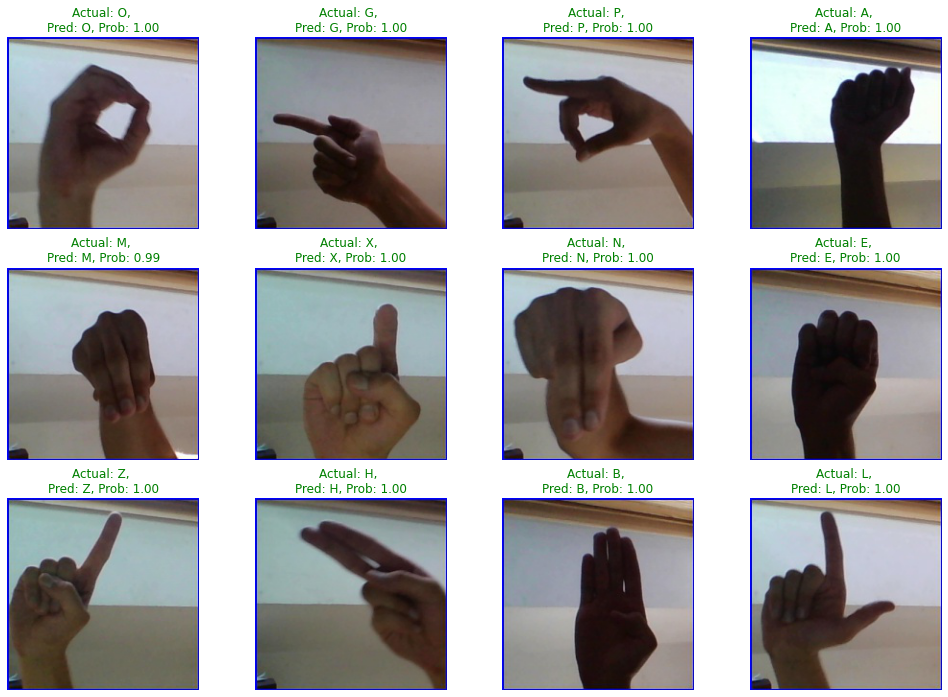

In [193]:
# Plotting predictions on test data
plt.figure(figsize=(17, 12))
for i in range(12):
  filepath = test_dir + "/" + test_fp[i]
  prob = np.max(test_prob_preds[i])
  label = test_labels[i]
  pred = test_pred_labels[i]
  _title_ = f"Actual: {label}, \nPred: {pred}, Prob: {prob:.2f}"
  col = "green" if label == pred else "red"

  # Plotting 
  plt.subplot(3, 4, i+1)
  img = plt.imread(filepath)
  plt.imshow(img)
  plt.axis(False)
  plt.title(_title_, color=col);

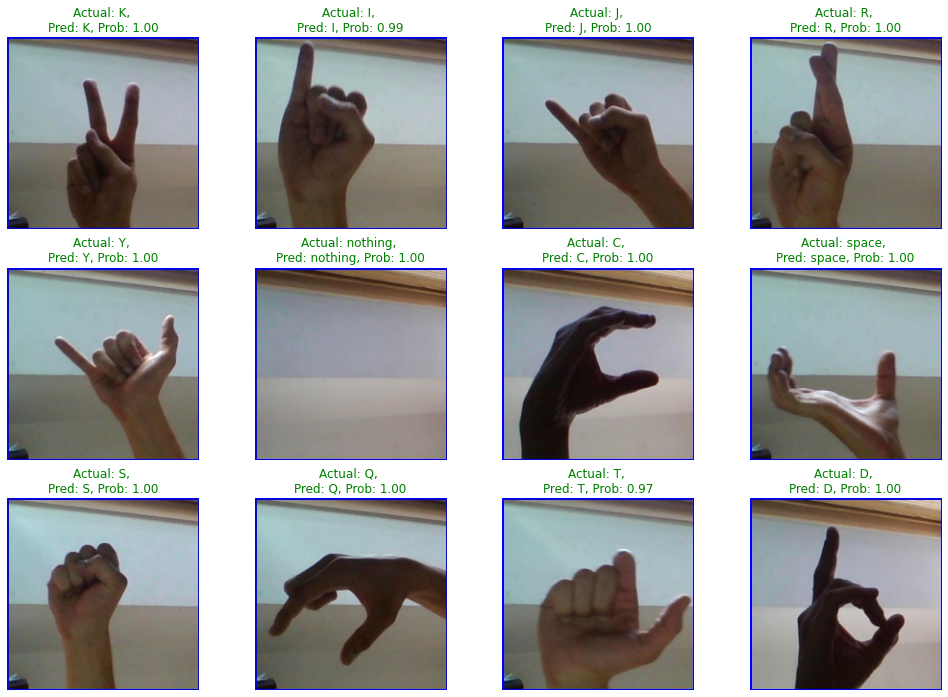

In [194]:
# Plotting predictions on test data
i_ = 12
plt.figure(figsize=(17, 12))
for i in range(12):
  i_ += 1
  filepath = test_dir + "/" + test_fp[i_]
  prob = np.max(test_prob_preds[i_])
  label = test_labels[i_]
  pred = test_pred_labels[i_]
  _title_ = f"Actual: {label}, \nPred: {pred}, Prob: {prob:.2f}"
  col = "green" if label == pred else "red"

  # Plotting 
  plt.subplot(3, 4, i+1)
  img = plt.imread(filepath)
  plt.imshow(img)
  plt.axis(False)
  plt.title(_title_, color=col);

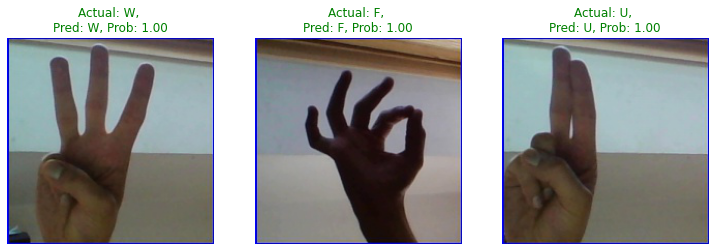

In [195]:
# Plotting predictions on test data
i_ = 24
plt.figure(figsize=(17, 4))
for i in range(3):
  i_ += 1
  filepath = test_dir + "/" + test_fp[i_]
  prob = np.max(test_prob_preds[i_])
  label = test_labels[i_]
  pred = test_pred_labels[i_]
  _title_ = f"Actual: {label}, \nPred: {pred}, Prob: {prob:.2f}"
  col = "green" if label == pred else "red"

  # Plotting 
  plt.subplot(1, 4, i+1)
  img = plt.imread(filepath)
  plt.imshow(img)
  plt.axis(False)
  plt.title(_title_, color=col);

In [212]:
# Encoding labels in numbers
num_labels = []
for i in test_labels:
  lab = np.where(np.array(classes) == i)[0][0]
  num_labels.append(lab)

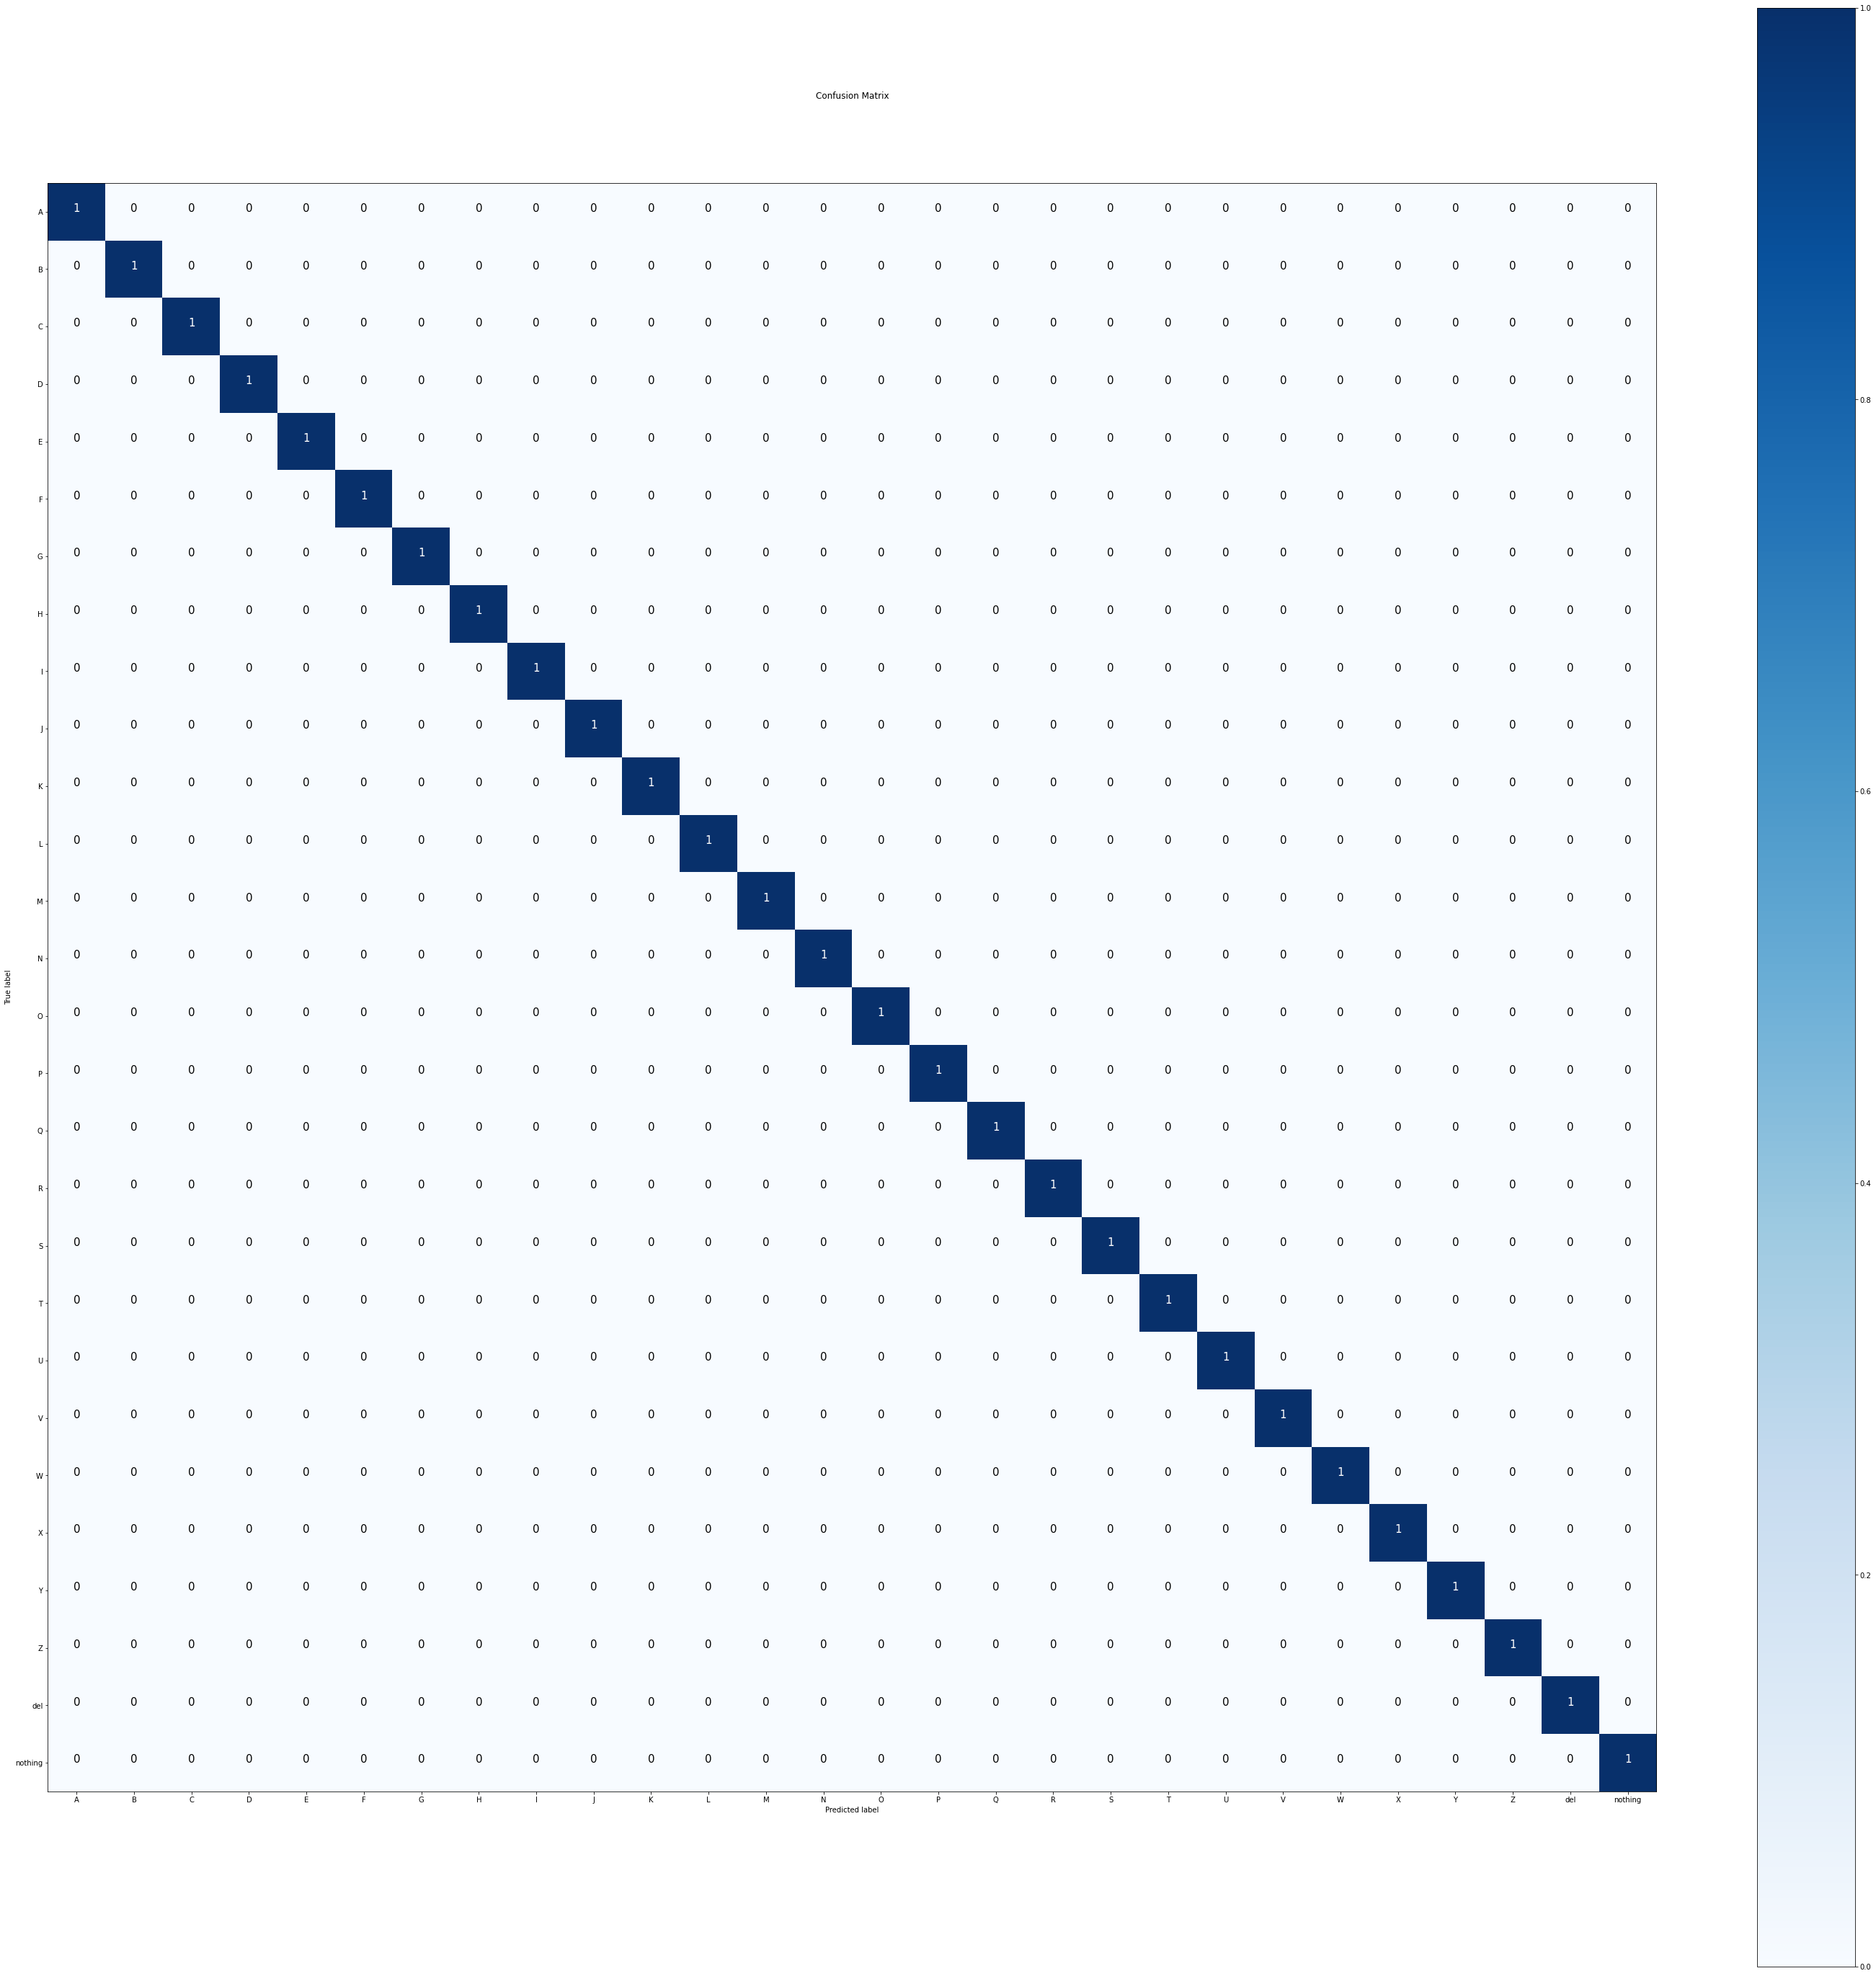

In [211]:
# Confusion matrix for test dataset
make_confusion_matrix(y_true=num_labels,
                      y_pred=test_preds.numpy(),
                      classes=classes,
                      figsize=(50, 50))